<a href="https://colab.research.google.com/github/emilyjokhoo/detecting_emotion_webcam/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#import scipy
import seaborn as sns
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import resample
import random
import os

from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from keras.optimizers import adam_v2

In [3]:
# loading dataset
os.chdir('/content/drive/MyDrive/lhl_final_project')
df = pd.read_csv('dataset.csv')
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


Preprocessing

In [5]:
del df['Usage']

In [6]:
emotion = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [7]:
df['emotion_names'] = df['emotion'].apply(lambda x: emotion[x])

In [8]:
emotion_plot = df['emotion'].value_counts(sort=False).reset_index()
emotion_plot.columns = ['Emotion', 'Count'] 
emotion_plot

,Emotion,Count
0,0,4953
1,2,5121
2,4,6077
3,6,6198
4,3,8989
5,5,4002
6,1,547


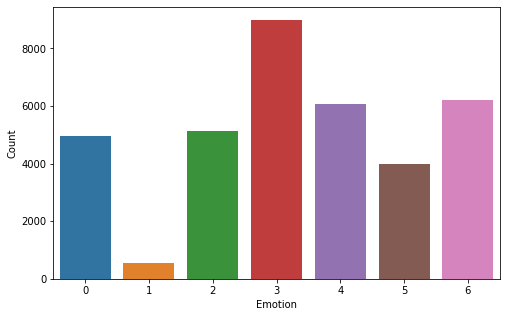

In [10]:
plt.figure(figsize=(8,5))
sns.barplot(x='Emotion', y='Count', data=emotion_plot)
plt.show()

In [12]:
# splitting train and test
train = df[:28711] # 80%
test = df[28711:] # 20%

In [13]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler()
train, y_train = oversampler.fit_resample(train, train.emotion)
train = train.sample(frac=1).reset_index(drop=True) 
# Shuffle the training set after oversampling in order to avoid blocks with same label

In [14]:
train_df = train['emotion'].value_counts(sort=False).reset_index()
train_df.columns = ['Emotion', 'Count'] 
train_df

,Emotion,Count
0,1,7215
1,0,7215
2,2,7215
3,5,7215
4,4,7215
5,6,7215
6,3,7215


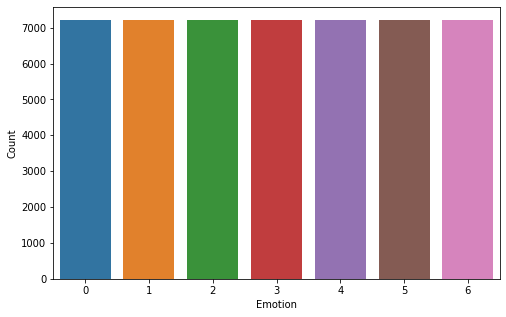

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='Emotion', y='Count', data=train_df)
plt.show()

In [ ]:
row, col = 3, 10
img_size = 20
fig, axes = plt.subplots(row, col, figsize=(img_size,img_size*row/col))
fig.tight_layout()
fig.subplots_adjust(hspace=.25)

for i in range(row):
    for k in range(col):
        ax = axes[i,k]
        j = np.random.randint(len(df.pixels)) 
        img = df.pixels[j].reshape(48,48)
        lbl = df.emotion[j].capitalize() 
        ax.set_title(f'{lbl}')
        ax.imshow(img, cmap='gray')

In [ ]:
X_train = []
for index, row in train.iterrows():
  k = row['pixels'].split(" ")
  X_train.append(np.array(k))

In [ ]:
X_test = []
for index, row in test.iterrows():
    k = row['pixels'].split(" ")
    X_test.append(np.array(k))

In [ ]:
X_train = np.array(X_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')

In [ ]:
newarr = np.array(X_train).reshape(50505, 48, 48, 1).astype('float32')
new_test = np.array(X_test).reshape(7176, 48, 48, 1).astype('float32')

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 15,
    horizontal_flip = True,
    width_shift_range=0.15,
    height_shift_range=0.15,
    fill_mode = 'nearest')

In [ ]:
batch_size = 32
testgen = ImageDataGenerator(rescale=1./255)
train_flow = datagen.flow(newarr, y=train['emotion'], batch_size=batch_size) 
test_flow = testgen.flow(new_test, y=test['emotion'], batch_size=batch_size)

In [ ]:
datagen.fit(newarr)

Modeling CNN

In [ ]:
 def FER_Model(input_shape=(48,48,1)):
   visible = Input(shape=input_shape, name='input')
   num_classes = 7
   # convo layer 1
   conv1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1')(visible)
   conv1 = BatchNormalization()(conv1)
   pool1 = MaxPooling2D(pool_size=(2,2), name = 'pool1')(conv1)
   drop1 = Dropout(0.3, name = 'drop1')(pool1)#the 2-nd block
   # convo layer 2
   conv2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2')(drop1)
   conv2 = BatchNormalization()(conv2)
   pool2 = MaxPooling2D(pool_size=(2,2), name = 'pool2')(conv2)
   drop2 = Dropout(0.3, name = 'drop2')(pool2)#the 3-rd block
   # convo layer 3
   conv3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3')(drop2)
   conv3 = BatchNormalization()(conv3)
   pool3 = MaxPooling2D(pool_size=(2,2), name = 'pool3')(conv3)
   drop3 = Dropout(0.3, name = 'drop3')(pool3)
   # convo layer 4
   conv4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv4')(drop3)
   conv4 = BatchNormalization()(conv4)
   pool4 = MaxPooling2D(pool_size=(2,2), name = 'pool4')(conv4)
   drop4 = Dropout(0.3, name = 'drop4')(pool4)
   # convo layer 5
   conv5 = Conv2D(1024, kernel_size=3, activation='relu', padding='same', name = 'conv5')(drop4)
   conv5 = BatchNormalization()(conv5)
   pool5 = MaxPooling2D(pool_size=(2,2), name = 'pool5')(conv5)
   drop5 = Dropout(0.3, name = 'drop5')(pool5)
   
   flatten = Flatten(name = 'flatten')(drop5)
   ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model 
   model = Model(inputs =visible, outputs = ouput)
   # Compile model
   opt = adam_v2.Adam(learning_rate=0.0001, decay=1e-6)
   model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
   return model

In [ ]:
batch_size = 32
model = FER_Model()
#opt = Adam(lr=0.0001, decay=1e-6)
opt = adam_v2.Adam(learning_rate=0.0001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 pool1 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 drop1 (Dropout)             (None, 24, 24, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 24, 24, 128)       73856     
                                                             

In [ ]:
num_epochs = 100
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(newarr) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow, validation_steps=len(new_test) / batch_size)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


1578/1578 [==============================] - 46s 22ms/step - loss: 2.3590 - accuracy: 0.1941 - val_loss: 1.9259 - val_accuracy: 0.2323
Epoch 2/100
1578/1578 [==============================] - 32s 20ms/step - loss: 1.8776 - accuracy: 0.2582 - val_loss: 1.8455 - val_accuracy: 0.3020
Epoch 3/100
1578/1578 [==============================] - 32s 20ms/step - loss: 1.7232 - accuracy: 0.3333 - val_loss: 1.6484 - val_accuracy: 0.3905
Epoch 4/100
1578/1578 [==============================] - 32s 21ms/step - loss: 1.5823 - accuracy: 0.3978 - val_loss: 1.4549 - val_accuracy: 0.4607
Epoch 5/100
1578/1578 [==============================] - 32s 20ms/step - loss: 1.4736 - accuracy: 0.4394 - val_loss: 1.5069 - val_accuracy: 0.4562
Epoch 6/100
1578/1578 [==============================] - 32s 20ms/step - loss: 1.3899 - accuracy: 0.4752 - val_loss: 1.4044 - val_accuracy: 0.4745
Epoch 7/100
1578/1578 [==============================] - 32s 21ms/step - loss: 1.3283 - accuracy: 0.4998 - val_loss: 1.3961 - val_

Tuning model

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
model_search = KerasClassifier(build_fn=FER_Model, verbose=0)

In [ ]:
batch_size = [32, 64, 100, 200, 300]
epochs = [50, 65, 85, 100,]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid_search_cv=GridSearchCV(model_search,param_grid,verbose=3,cv=2)
grid_result = grid_search_cv.fit(newarr, train['emotion'])

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Testing on Webcam

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

import cv2
os.chdir('/content/drive/MyDrive/lhl_final_project')
os.chdir('/content/drive/MyDrive/lhl_final_project/haarcascade')
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # example of loading an image with the Keras API
  from keras.preprocessing.image import load_img
  # load the image

  from PIL import Image


  # get OpenCV format image
  img = js_to_image(data)
  
  load = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
  cv2.imwrite(filename, load)
  img = Image.open('photo.jpg')
  gray = img.resize((48,48), Image.ANTIALIAS)
  gray.save('test_photo.jpg')
  gray_2 = cv2.imread('test_photo.jpg')  # grayscale img
  
  faces = face_cascade.detectMultiScale(load)
  print(faces)

  gray_3 = gray_2[:,:,0]
  print(gray_3.shape)

  img_3 = gray_3.reshape(1, 48, 48, 1)
  pred = model.predict(img_3)
  emotion = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
  lst = pred[0]
  lst = list(lst)
  index = lst.index(0)
  text = emotion[index]
  print(faces)
  for (x,y,w,h) in faces:
    img_2 = cv2.rectangle(load,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.putText(img_2, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
  cv2.imwrite(filename, img_2)
  print(text)
  print(filename)

  
  return filename

In [ ]:
if True:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  display(Image(filename))

In [ ]:
## accuracy and loss 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

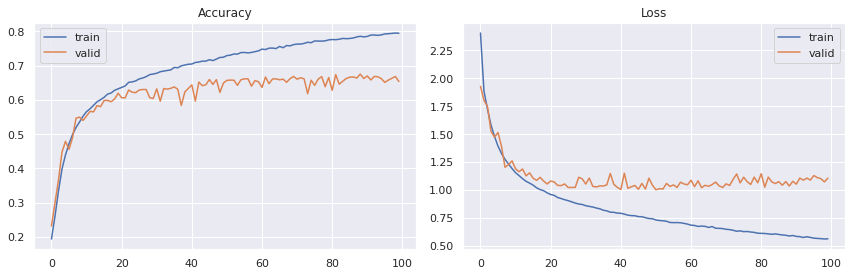

In [ ]:
from matplotlib import pyplot

sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [ ]:
## confusion

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
# #calculate precision and recall
# precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# #create precision recall curve
# fig, ax = plt.subplots()
# ax.plot(recall, precision, color='purple')

# #add axis labels to plot
# ax.set_title('Precision-Recall Curve')
# ax.set_ylabel('Precision')
# ax.set_xlabel('Recall')

# #display plot
# plt.show()

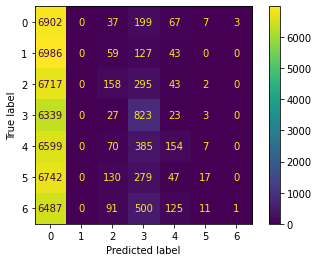

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(newarr)
y_pred = np.argmax(y_pred,axis=1)
y_true = train['emotion']


cm = confusion_matrix(y_true,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# pyplot.savefig("confusion_matrix_dcnn.png")

# print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
# print(classification_report(np.argmax(y_test, axis=1), yhat_valid))

In [ ]:
# saving model
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# print("Saved model to disk")

In [ ]:
# # Loading the saved model
# from tensorflow.keras.models import model_from_json
# model = model_from_json(open("model_arch.json", "r").read())
# model.load_weights('model.h5')